In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from model import VAEModule, AutoEncoder
from dataloader import VAESegLoader


class Config:
    # model
    seq_len = 10
    in_channel = 1
    win_size = 64
    latent_dim = 10
    hidden_num_units = 64
    sigma = 0.1
    sigma2_offset = 0.01
    hidden_num_units_lstm = 64
    num_layers_lstm = 1
    
    # training
    n_epochs = 15
    lr = 1e-3
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()



In [3]:

import matplotlib.pyplot as plt
import utils

generator = utils.Synthetic_heteroscedasticData_generator(0.7, 2, 5, 20)

data = generator.get_data(1000)

y_tildes = data['y_tilde'].clone().detach()
y_tildes_test = data['y_disturb_tilde'].clone().detach()

scaler = StandardScaler()
scaler.fit(y_tildes)
y_tildes = scaler.transform(y_tildes)
y_tildes_test = scaler.transform(y_tildes_test)
ys = data['y'].clone().detach()

print(y_tildes.shape)


(1000, 1)


In [618]:

import matplotlib.pyplot as plt
import utils

generator = utils.Synthetic_heteroscedasticData_generator(2, 2, 5, 40)
data = generator.get_data(1000)

y_tildes = data['y_tilde'].clone().detach()
y_tildes_test = data['y_disturb_tilde'].clone().detach()

scaler = StandardScaler()
scaler.fit(y_tildes)
y_tildes = scaler.transform(y_tildes)
y_tildes_test = scaler.transform(y_tildes_test)
ys = data['y'].clone().detach()

print(y_tildes.shape)


(1000, 1)


In [9]:

import matplotlib.pyplot as plt
import utils

generator = utils.Synthetic_heteroscedasticData_generator(0.7, 2, 5, 40)
data = generator.get_data(1000)

y_tildes = data['y_tilde'].clone().detach()
y_tildes_test = data['y_disturb_tilde'].clone().detach()

scaler = StandardScaler()
scaler.fit(y_tildes)
y_tildes = scaler.transform(y_tildes)
y_tildes_test = scaler.transform(y_tildes_test)
ys = data['y'].clone().detach()

print(y_tildes.shape)


(1000, 1)


In [42]:
import utils
import torch
import os
print(os.getcwd())
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torch.utils.data import Dataset, DataLoader
from dataloader import VAESegLoader
import matplotlib.pyplot as plt
from model import MLP
from bae_ensemble import BAE_Ensemble
M = 20
config.batch_size = 16
bvae_ens = BAE_Ensemble(M, AutoEncoder, config)
bvae_ens.toDevice(config.device)


config.n_epochs = 5
def valid(data_loader):
    bvae_ens.eval()
    total_loss = []
    with torch.no_grad():
        for i, x in enumerate(data_loader):
            x = x.view(config.batch_size, config.in_channel, -1)
            x = x.to(config.device)
            loss = bvae_ens.fit(x)
            total_loss.append(loss.item())
    return np.average(total_loss)


def train(data_loader, bvae_ens, config, tunning=False):
    bvae_ens.train()
    for epoch in range(config.n_epochs):
        print(f"-------------- epoch: {epoch} ----------------")
        total_loss = []
        for i, x in enumerate(data_loader):
            bvae_ens.zero_optimizers()
            x = x.view(config.batch_size, config.in_channel, -1) 
            x = x.to(config.device)
            x.requires_grad = False
            loss = bvae_ens.fit(x)
            total_loss.append(loss.item())
            if (i + 1) % 20 == 0:
                print(f"     batch: {i + 1}, batch_loss: {loss.item()}     ")
            loss.backward()
            bvae_ens.step_optimizers()
        if tunning:
            bvae_ens.adjust_lr(epoch)
        train_loss = np.average(total_loss)
        valid_loss = valid(test_syn_dataloader)
        print(f">>>> Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}<<<<")
    
test = y_tildes_test
training = y_tildes

train_syn_dataset = VAESegLoader(training, config.win_size, "train")
train_syn_dataloader =  DataLoader(
    dataset = train_syn_dataset, 
    batch_size = config.batch_size,
    shuffle=True,
    drop_last=True,
)

test_syn_dataset = VAESegLoader(test, config.win_size, "test")
test_syn_dataloader =  DataLoader(
    dataset = test_syn_dataset, 
    batch_size = config.batch_size,
    shuffle=True,
    drop_last=True,
)

# heter 

train(train_syn_dataloader, bvae_ens, config)
print("-------------- logvar tunning --------------")
bvae_ens.set_loss_type('rnll')  
config.n_epochs = 10
bvae_ens.tunning_var(1e-4)

train(train_syn_dataloader, bvae_ens, config)
# config.n_epochs = 10
# bvae_ens.tunning_var(1e-5)
# train(train_syn_dataloader, bvae_ens, config)

/home/new_lab/test/ensemble_bae
-------------- epoch: 0 ----------------
     batch: 20, batch_loss: 170.4956817626953     
     batch: 40, batch_loss: 124.8212890625     
>>>> Epoch: 0, train_loss: 150.1169784808981, valid_loss: 133.98230664483432<<<<
-------------- epoch: 1 ----------------
     batch: 20, batch_loss: 121.46076965332031     
     batch: 40, batch_loss: 120.481689453125     
>>>> Epoch: 1, train_loss: 121.15381977475923, valid_loss: 133.3215935805748<<<<
-------------- epoch: 2 ----------------
     batch: 20, batch_loss: 121.33675384521484     
     batch: 40, batch_loss: 119.7768783569336     
>>>> Epoch: 2, train_loss: 120.93795697442417, valid_loss: 133.26558382757779<<<<
-------------- epoch: 3 ----------------
     batch: 20, batch_loss: 120.72328186035156     
     batch: 40, batch_loss: 120.8846206665039     
>>>> Epoch: 3, train_loss: 120.87148087600181, valid_loss: 133.11253120159282<<<<
-------------- epoch: 4 ----------------
     batch: 20, batch_loss: 12

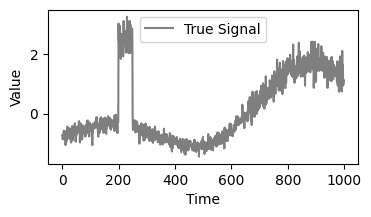

In [5]:
test = y_tildes_test
training = y_tildes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
axs.plot(test.flatten(), label='True Signal', alpha=0.5, color='black')
# ys = scaler.transform(data['y'].clone().detach())
# axs[0].plot(ys , label='clean signal')
axs.legend()
# axs.grid()
axs.set_xlabel("Time")
axs.set_ylabel("Value")
# axs.set_ylim(-2, 6)
# plt.savefig("toy_example_30.png", bbox_inches='tight', dpi=300)
plt.show() 

(20, 960)


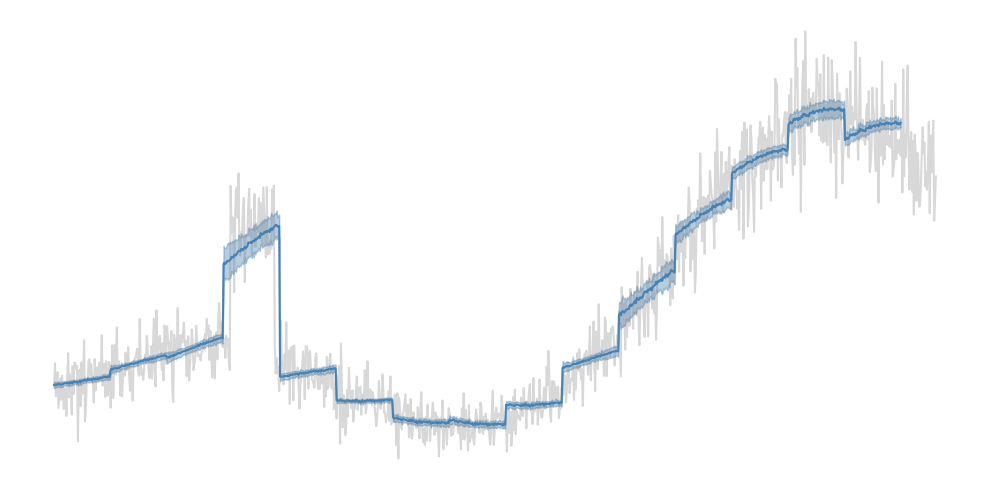

In [6]:
# epistemic uncertianty for paper
import utils
from dataloader import VAEReconLoader

test_recons_dataset = VAEReconLoader(test, config.win_size, "test")

batch_size = 1
test_recons_dataloader =  DataLoader(
    dataset = test_recons_dataset, 
    batch_size = batch_size,
    shuffle=False,
    drop_last=True,
)

# for visualization
recstructed_signals = [ [] for _ in range(M)]

bvae_ens.eval()

for i, x in enumerate(test_recons_dataloader):
    x = x.view(batch_size, config.in_channel, -1)
    x = x.to(config.device)
    prediction = bvae_ens.predict_stack_values(x)
    for m in range(M):
        recstructed_signals[m].extend(prediction[m].detach().cpu().numpy().flatten())
recstructed_signals = np.array(recstructed_signals)
print(recstructed_signals.shape)


recstructed_signals_std = np.std(recstructed_signals, axis=0)
recstructed_signals_mean = np.mean(recstructed_signals, axis=0)
upper_bound = recstructed_signals_mean + 2 * recstructed_signals_std
lower_bound = recstructed_signals_mean - 2 * recstructed_signals_std
# upper_bound = np.convolve(upper_bound, np.ones(10)/10, mode='same')
# lower_bound = np.convolve(lower_bound, np.ones(10)/10, mode='same')

recstructed_signals_any = np.convolve(recstructed_signals[0, ], np.ones(20)/20, mode='same')
fig, ax = plt.subplots(figsize=(10, 5))

ax.fill_between(np.arange(len(recstructed_signals_mean)), upper_bound, lower_bound, color='steelblue', alpha=0.4, label='uncertainty')
ax.plot(test.flatten(), label='True Signal', color='gray', alpha=0.3)
ax.plot(recstructed_signals_mean, color='steelblue')

ax.set_xticks([])  # 去掉 x 轴刻度
ax.set_yticks([])  # 去掉 y 轴刻度

ax.spines['top'].set_visible(False)     # 去掉上边框
ax.spines['right'].set_visible(False)   # 去掉右边框
ax.spines['bottom'].set_visible(False)  # 去掉下边框
ax.spines['left'].set_visible(False)    # 去掉左边框
# plt.savefig('epistemic_example_4_24.png', dpi=300)
plt.tight_layout()
plt.show()



(1000, 1) (1000, 1)


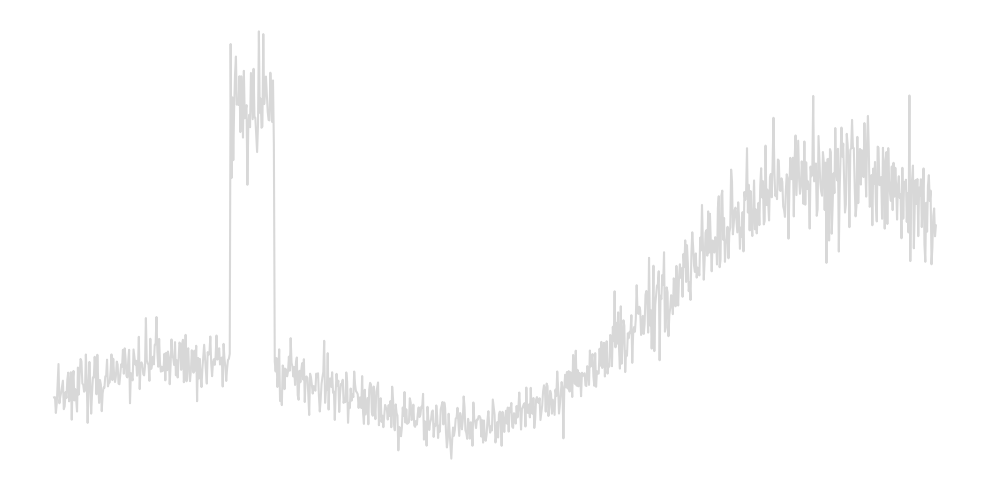

In [152]:
# plotting aleatoric for paper

y_std = generator.get_y_std(data['y_disturb']).numpy()
print(y_tildes_test.shape,y_std.shape)
fig, ax = plt.subplots(figsize=(10, 5))
# plt.figure(figsize=(10, 6))

ax.plot(data['y_disturb_tilde'].numpy(), alpha=0.3, color='gray')
upper_bound = data['y_disturb'].numpy() + 2 * y_std
lower_bound = data['y_disturb'].numpy() - 2 * y_std

# ax.fill_between(np.arange(y_tildes_test.shape[0]), upper_bound.flatten(), lower_bound.flatten(), color='ForestGreen', alpha=0.2, label='uncertainty')
# ax.plot(data['y_disturb'].numpy(), color='ForestGreen')
# ax[2].fill_between(np.arange(len(y_tildes_test)), upper_bound, lower_bound, color='blue', alpha=0.1, label='uncertainty')
# plt.xlabel('Time')#, fontsize=8, labelpad=1)
# # plt.xticks(fontsize=7)
# plt.ylabel('Value')#, fontsize=8, labelpad=1)
# plt.yticks(fontsize=7)
# plt.fill_between((180, 310), -3,3, color='red', alpha=0.2, label='anomaly')



ax.set_xticks([])  # 去掉 x 轴刻度
ax.set_yticks([])  # 去掉 y 轴刻度

ax.spines['top'].set_visible(False)     # 去掉上边框
ax.spines['right'].set_visible(False)   # 去掉右边框
ax.spines['bottom'].set_visible(False)  # 去掉下边框
ax.spines['left'].set_visible(False)    # 去掉左边框
plt.savefig('example2_4_24.png', dpi=300)
plt.tight_layout()
plt.show()



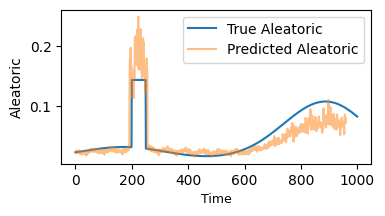

In [43]:
import utils
from dataloader import VAEReconLoader
# anomaly detection only vae on test


test_recons_dataset = VAEReconLoader(test, config.win_size, "test")

batch_size = 1
test_recons_dataloader =  DataLoader(
    dataset = test_recons_dataset, 
    batch_size = batch_size,
    shuffle=False,
    drop_last=True,
)

# for visualization
recstructed_signal = []
approx_var_heter = []

bvae_ens.eval()

for i, x in enumerate(test_recons_dataloader):
    x = x.view(batch_size, config.in_channel, -1)
    # prediction = bvae_ens.predict_mean(x) # (10, batch_size, in_channel, win_size)
    x = x.to(config.device)
    prediction, logvar = bvae_ens.predict_mean_logvar(x)
    # logvar = logvar_net(x)
    var = logvar

    recstructed_signal.extend(prediction.detach().cpu().numpy().flatten())
    approx_var_heter.extend(var.detach().cpu().numpy().flatten())

recstructed_signal = np.array(recstructed_signal)
approx_var_heter = np.array(approx_var_heter)
# approx_var_heter = utils.remove_outliers_iqr(approx_var_heter)

# ================== plot aleatoric result ==================
true_var_heter = ((generator.get_y_std(data['y_disturb']) / scaler.scale_)**2).detach().numpy().flatten()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))


# axs.plot(np.random.randn(*true_var_heter.shape) * np.sqrt(true_var_heter), label='Predicted Aleatoric', alpha=0.4)
# # axs[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
# axs.plot(np.random.randn(*approx_var_heter.shape) * np.sqrt(approx_var_heter), label='True Aleatoric', alpha=0.4)
axs.plot(true_var_heter, label='True Aleatoric')
axs.plot(approx_var_heter, label='Predicted Aleatoric', alpha=0.5)
# axs.grid()
# axs.set_ylim(0, 1)
axs.legend()
axs.set_xlabel("Time", fontsize=9)
axs.set_ylabel("Aleatoric", fontsize=10)
# plt.savefig("result_4_28/anomaly_40_nll.png",bbox_inches='tight', dpi=300)
plt.show() 



(960,)


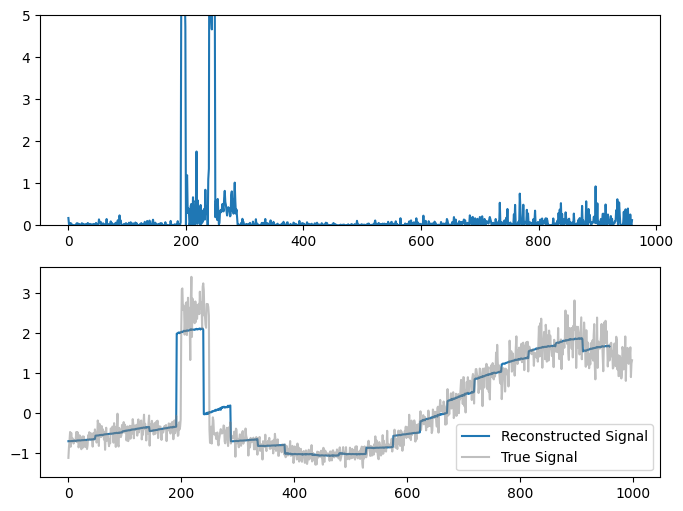

In [73]:
recons_error = (test.flatten()[:len(recstructed_signal)] - recstructed_signal.flatten())**2
print(recons_error.shape)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axs[0].plot(recons_error, label='Reconstruction Error')
axs[0].set_ylim(0, 5)
axs[1].plot(recstructed_signal, label='Reconstructed Signal')
axs[1].plot(test.flatten(), label='True Signal', alpha=0.5, color='gray')
plt.legend()
plt.show()

(960,)


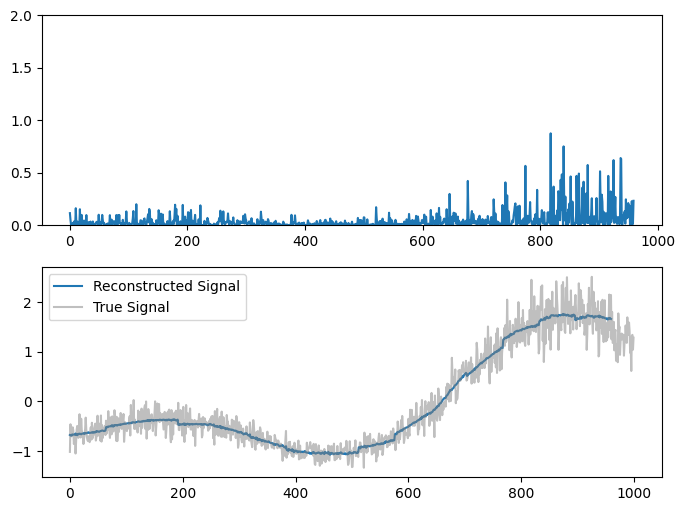

In [154]:
test_recons_dataset = VAEReconLoader(training, config.win_size, "test")

batch_size = 1
test_recons_dataloader =  DataLoader(
    dataset = test_recons_dataset, 
    batch_size = batch_size,
    shuffle=False,
    drop_last=True,
)

# for visualization
recstructed_signal = []


bvae_ens.eval()

for i, x in enumerate(test_recons_dataloader):
    x = x.view(batch_size, config.in_channel, -1)
    # prediction = bvae_ens.predict_mean(x) # (10, batch_size, in_channel, win_size)
    x = x.to(config.device)
    prediction, logvar = bvae_ens.predict_mean_logvar(x)
    recstructed_signal.extend(prediction.detach().cpu().numpy().flatten())


recstructed_signal = np.array(recstructed_signal)
recons_error = (training.flatten()[:len(recstructed_signal)] - recstructed_signal.flatten())**2
print(recons_error.shape)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axs[0].plot(recons_error, label='Reconstruction Error')
axs[0].set_ylim(0, 2)
axs[1].plot(recstructed_signal, label='Reconstructed Signal')
axs[1].plot(training.flatten(), label='True Signal', alpha=0.5, color='gray')
plt.legend()
plt.show()

In [630]:
import glob
import pandas as pd
import numpy as np

anomaly_value = 30.0
files = glob.glob(f"./result_4_28/*_anomaly_{anomaly_value}.csv")

mse_mean = []
mse_std = []
for file in files:
    df = pd.read_csv(file)
    print(file)
    mse_mean.append((df['nll'].values.mean(), df['rnll'].values.mean(), df['beta_nll'].values.mean(), df['mts_nll'].values.mean()))
    mse_std.append((df['nll'].values.std(), df['rnll'].values.std(), df['beta_nll'].values.std(), df['mts_nll'].values.std()))
mse_mean = np.array(mse_mean)
mse_std = np.array(mse_std)
print(mse_mean.shape)
print(mse_std.shape)
print(mse_mean)
print(mse_std)

./result_4_28/alea_1.414_anomaly_30.0.csv
./result_4_28/alea_0.707_anomaly_30.0.csv
./result_4_28/alea_1.0_anomaly_30.0.csv
(3, 4)
(3, 4)
[[0.02657251 0.021299   0.02555075 0.02871936]
 [0.01213469 0.00986183 0.01771598 0.02501145]
 [0.020762   0.01320369 0.0229969  0.03196653]]
[[0.00656573 0.00520324 0.00681083 0.00828633]
 [0.00686758 0.00343007 0.00333884 0.0055298 ]
 [0.0050611  0.00360438 0.01016538 0.01332754]]


In [23]:
import glob
import pandas as pd
import numpy as np

anomaly_value = 30.0
lambda1 = 4
lambda2 = 3
files = glob.glob(f"./toy_example_result_5_18/*_anomaly_{anomaly_value}_lambda1_{lambda1}_lambda2_{lambda2}.csv")

mse_mean = []
mse_std = []
for file in files:
    df = pd.read_csv(file)
    print(df.iloc())
    for i in range(0, len(df), 5):
        selection = df.iloc[i: i+5]
        mse_mean.append((selection['nll'].values.mean(), selection['rnll'].values.mean(), selection['beta_nll'].values.mean(), selection['mts_nll'].values.mean()))
        mse_std.append((selection['nll'].values.std(), selection['rnll'].values.std(), selection['beta_nll'].values.std(), selection['mts_nll'].values.std()))
mse_mean = np.array(mse_mean)
mse_std = np.array(mse_std)
for i, lr in enumerate([1e-3, 5e-4, 1e-4, 5e-5]):
    print(f"lr: {lr}", end=", ")
    for j, method in enumerate(['nll', 'rnll', 'beta_nll', 'mts_nll']):
        print(f"{method}: {mse_mean[i][j] * 100:.6f} ± {mse_std[i][j]:.6f}", end="  ")
    print()

# print(mse_mean.shape)
# print(mse_std.shape)
# print(mse_mean)
# print(mse_std)

lr: 0.001, nll: 2.221736 ± 0.019098  rnll: 0.224960 ± 0.000348  beta_nll: 2.714396 ± 0.023847  mts_nll: 2.821413 ± 0.014276  
lr: 0.0005, nll: 2.443628 ± 0.010943  rnll: 0.959498 ± 0.008467  beta_nll: 2.545999 ± 0.012653  mts_nll: 3.123045 ± 0.017238  
lr: 0.0001, nll: 0.177369 ± 0.000791  rnll: 0.110168 ± 0.000269  beta_nll: 0.201621 ± 0.001309  mts_nll: 0.228627 ± 0.001137  
lr: 5e-05, nll: 0.097863 ± 0.000337  rnll: 0.137358 ± 0.000269  beta_nll: 0.080885 ± 0.000074  mts_nll: 0.100704 ± 0.000304  
